In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize

In [2]:
df = pd.read_csv('IMDB_movie_details.csv')
df.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,title
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"['Action', 'Thriller']",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",Giochi di potere
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,['Comedy'],6.6,2013-11-01,Four boys around the age of 10 are friends in ...,Last Vegas
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"['Comedy', 'Romance']",6.7,2002-04-11,NaN,Wet Hot American Summer
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"['Adventure', 'Drama', 'Western']",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...,Il tesoro della Sierra Madre
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"['Comedy', 'Drama', 'Romance']",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...,Election


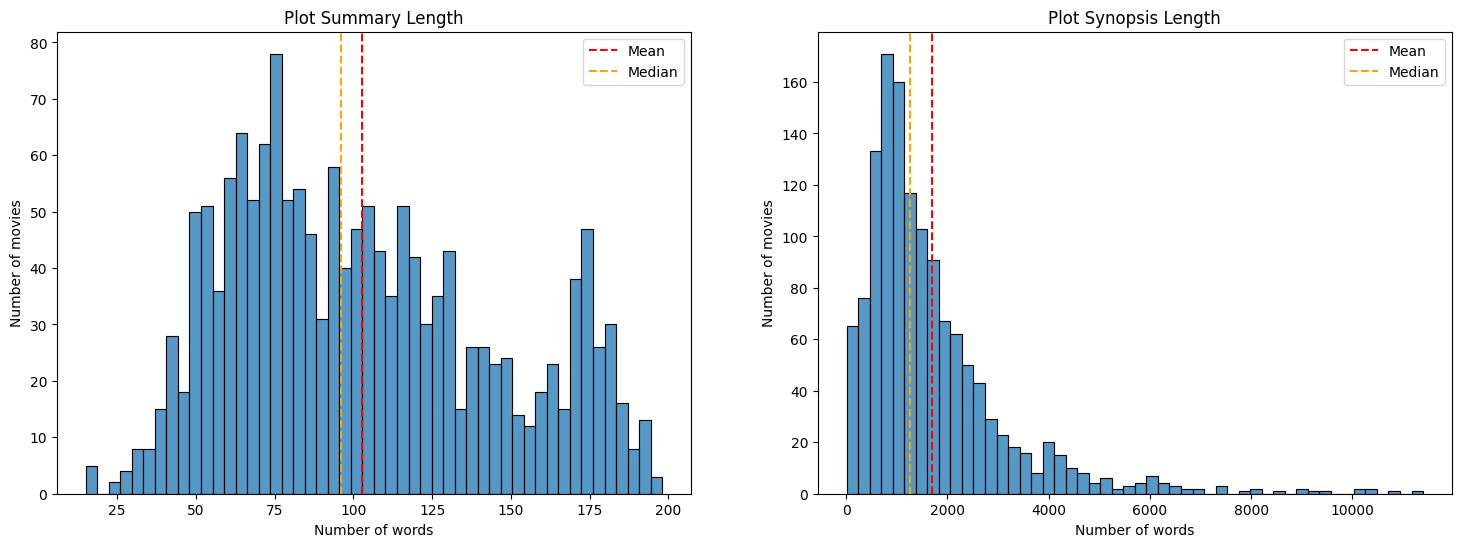

In [3]:
# plot average length of plot summary and synopsis
df['plot_summary_len'] = df.plot_summary.apply(lambda x: len(x.split()))
mov_temp = df[df.plot_synopsis.apply(lambda x: type(x) == str)].copy()
mov_temp['plot_synopsis_len'] = mov_temp.plot_synopsis.apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(df['plot_summary_len'], bins=50, ax=ax[0])
#put vertical line on the mean and median and show their values in the legend
ax[0].axvline(df['plot_summary_len'].mean(), color='red', linestyle='--', label='Mean')
ax[0].axvline(df['plot_summary_len'].median(), color='orange', linestyle='--')
ax[0].set_title('Plot Summary Length')
ax[0].set_xlabel('Number of words')
ax[0].set_ylabel('Number of movies')
ax[0].legend({'Mean':df['plot_summary_len'].mean(),'Median':df['plot_summary_len'].median()})

sns.histplot(mov_temp['plot_synopsis_len'], bins=50, ax=ax[1])
ax[1].axvline(mov_temp['plot_synopsis_len'].mean(), color='red', linestyle='--')
ax[1].axvline(mov_temp['plot_synopsis_len'].median(), color='orange', linestyle='--')
ax[1].set_title('Plot Synopsis Length')
ax[1].set_xlabel('Number of words')
ax[1].set_ylabel('Number of movies')
ax[1].legend({'Mean':mov_temp['plot_synopsis_len'].mean(),'Median':mov_temp['plot_synopsis_len'].median()})
plt.show()

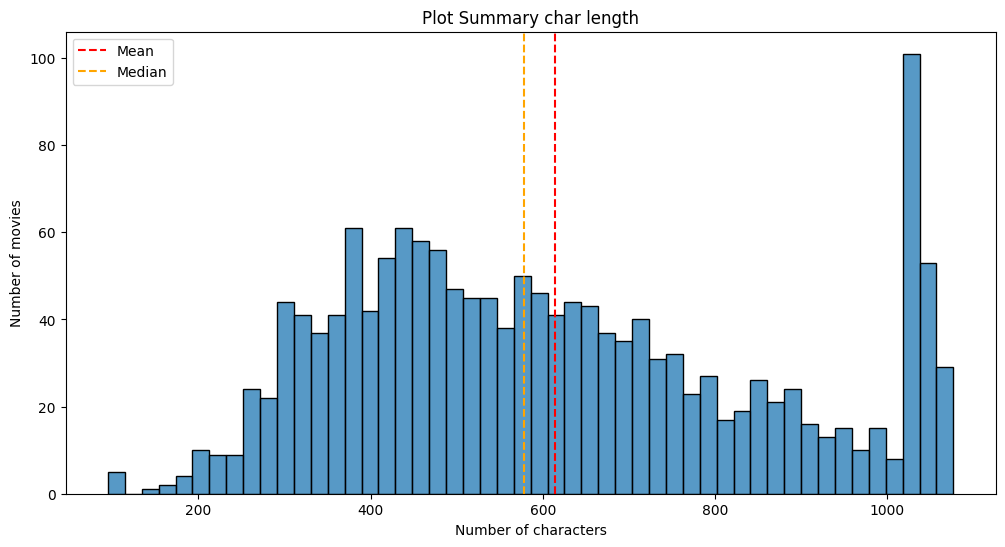

In [4]:
text_len = pd.DataFrame(columns = ['text_length_words', 'text_length_chars'])

text_len['text_length_chars'] = df['plot_summary'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(text_len['text_length_chars'], bins=50)
plt.title('Plot Summary char length')
plt.xlabel('Number of characters')
plt.ylabel('Number of movies')
plt.axvline(text_len['text_length_chars'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(text_len['text_length_chars'].median(), color='orange', linestyle='--', label='Median')
plt.legend()
plt.show()

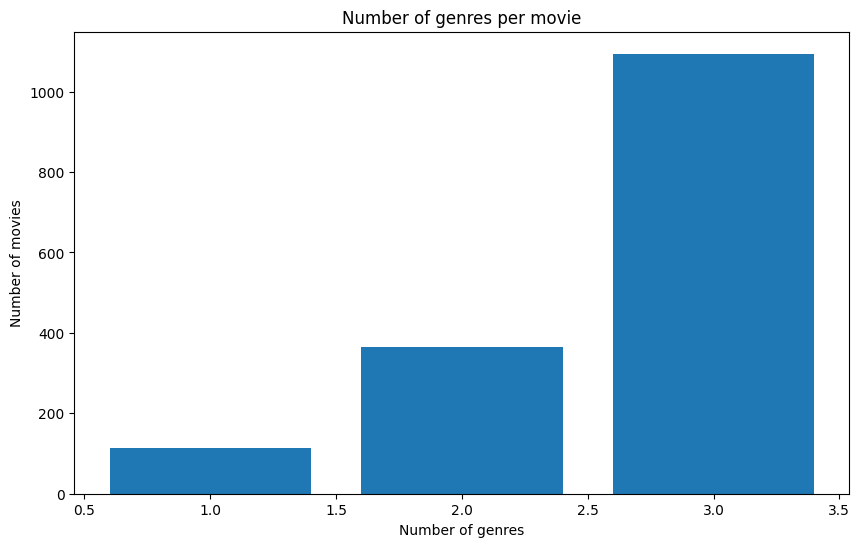

In [5]:
# get the # genres per movie
df['genre'] = df['genre'].str.split(',')
gen_len =  df['genre'].apply(lambda x: len(x))
gen_lens = dict(gen_len.value_counts())
#plot the content of this dictionary
plt.figure(figsize=(10,6))
plt.bar(gen_lens.keys(), gen_lens.values())
plt.title('Number of genres per movie')
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.show()

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocessing(corpus): #revise this
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    corpus = re.sub(r'[^\w\s]', '', corpus)
    tokens = word_tokenize(corpus)
    tokens = [word.lower() for word in tokens]
    tokens = [word.replace(',' , '') for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

df['processed'] = df.plot_summary.astype(str).apply(lambda x: preprocessing(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gigimancinelli./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import os 
from sentence_transformers import SentenceTransformer

to_encode = pd.DataFrame(df['processed'].values.tolist())

def embed_text(embs):

  if not os.path.exists('../embedding_cache_path.npy'):
    print('Start calculating embeddings...')
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    print(f'... using {model}')
    embeddings = model.encode(embs)

    np.save('embedding_cache_path.npy',embeddings )
  else:
    print('Loading existing embeddings...')
    embeddings = np.load('./embedding_cache_path.npy')
    
  return embeddings

In [ ]:
embed_text

In [ ]:
import networkx as nx

G = nx.Graph()

[G.add_node(index, title = row['title'], genre = row['genre'], plot_summary = row['plot_summary']) for index, row in df.iterrows()]

for index, row in df.iterrows():
    for i1, r1 in df[index+1:].iterrows():
        cosim =  util.pytorch_cos_sim(row['embeddings'] , r1['embeddings'])
        if cosim > 0.44:
            G.add_edge(index, i1, weight = cosim[0][0])

#remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))



In [ ]:
G.remove_node(832)

In [ ]:
import matplotlib.pyplot as plt
degrees = [G.degree(n) * 100 for n in G.nodes()]  # Scale by 10 for better visualization

# Draw the graph
plt.figure(figsize=(20, 20))
nx.draw(G, node_size=degrees, with_labels=True, font_weight='bold')

In [ ]:
A_d = nx.adjacency_matrix(G)
print(A_d.todense())

In [ ]:
import seaborn as sns

A_d = nx.adjacency_matrix(G)
sns.heatmap(A_d.todense(),
            annot=True,
            cmap = 'viridis',
            xticklabels=G.nodes(),
            yticklabels=G.nodes())

In [ ]:
betw_centr = dict(sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse = True))

print(betw_centr)


In [ ]:
close_cent = dict(sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse = True))
close_cent